In [1]:
import re
import sys
import io
import numpy as np
import itertools
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

!pip install nolds
import nolds


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


# Synthetic Data Generation

In [2]:
def Lorentz_System(state, sigma, rho, beta):
    x, y, z = state
    x_dot = sigma*(y-x)
    y_dot = x*(rho-z) - y
    z_dot = x*y - beta*z

    return np.array([x_dot, y_dot, z_dot])

### Runga Kutta

In [3]:
def rk4(state, dt, sigma, rho, beta):
    k1 = Lorentz_System(state, sigma, rho, beta)
    k2 = Lorentz_System(state + 0.5 * dt * k1, sigma, rho, beta)
    k3 = Lorentz_System(state + 0.5 * dt * k2, sigma, rho, beta)
    k4 = Lorentz_System(state + dt * k3, sigma, rho, beta)

    return state + (dt*((k1 + 2*k2 + 2*k3 + k4)/6.0))
    

Now, let's visualize the Lorenz attractor using N = 50,000

In [4]:
dt = 0.01
N = 50000
sigma, rho, beta = 10.0, 28.0, 8.0/3.0
x0, y0, z0 = 1.0, 1.0, 1.0
state = np.array([x0, y0, z0])

trajectory = np.empty((N+1, 3))
trajectory[0] = state

for i in range(1, N+1):
    state = rk4(state, dt, sigma, rho, beta)
    trajectory[i] = state

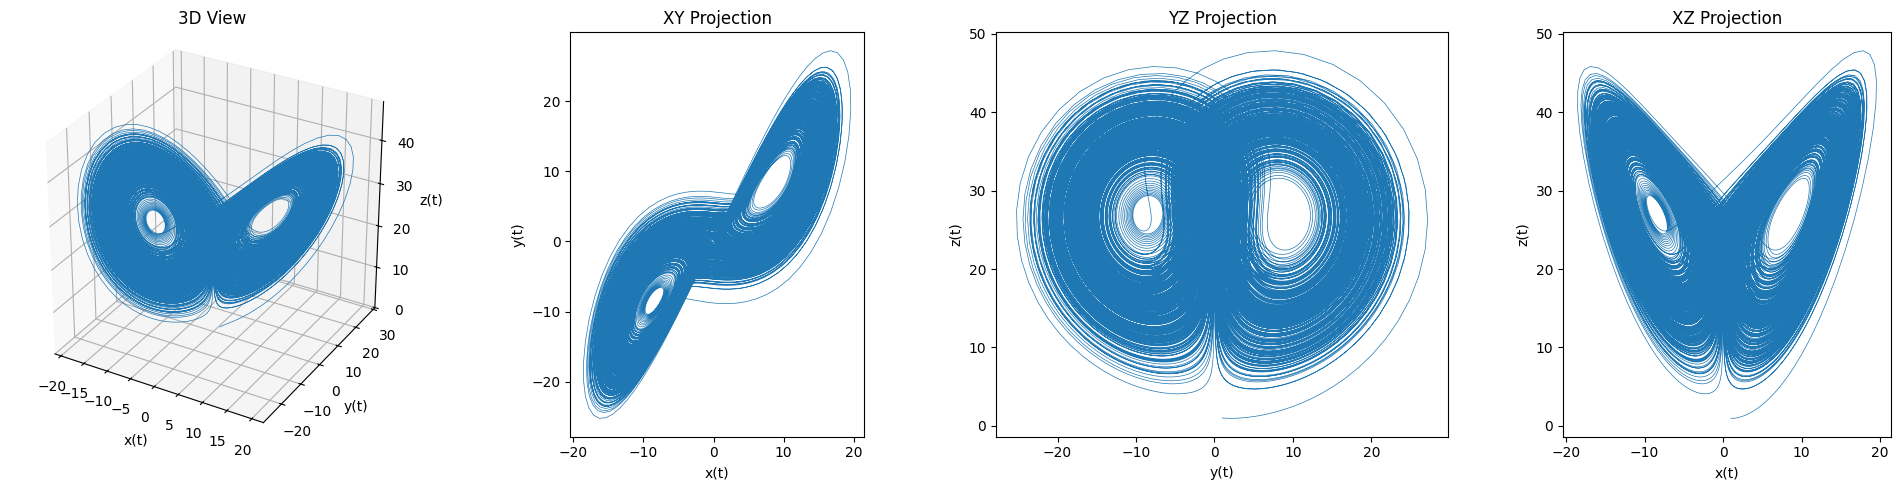

In [5]:
# Subsample trajectory to plot fewer points
thin = trajectory[::1]

fig = plt.figure(figsize=(20, 5))

# 3D
ax0 = fig.add_subplot(1, 4, 1, projection='3d')
ax0.plot(thin[:, 0], thin[:, 1], thin[:, 2], lw=0.5)
ax0.set_xlabel('x(t)'); ax0.set_ylabel('y(t)'); ax0.set_zlabel('z(t)')
ax0.set_title('3D View')
ax0.set_box_aspect((1,1,1))  # equal aspect in 3D

# XY
ax1 = fig.add_subplot(1, 4, 2)
ax1.plot(thin[:, 0], thin[:, 1], lw=0.5)
ax1.set_xlabel('x(t)'); ax1.set_ylabel('y(t)')
ax1.set_title('XY Projection')
ax1.set_aspect('equal', 'box')

# YZ
ax2 = fig.add_subplot(1, 4, 3)
ax2.plot(thin[:, 1], thin[:, 2], lw=0.5)
ax2.set_xlabel('y(t)'); ax2.set_ylabel('z(t)')
ax2.set_title('YZ Projection')
ax2.set_aspect('equal', 'box')

# XZ
ax3 = fig.add_subplot(1, 4, 4)
ax3.plot(thin[:, 0], thin[:, 2], lw=0.5)
ax3.set_xlabel('x(t)'); ax3.set_ylabel('z(t)')
ax3.set_title('XZ Projection')
ax3.set_aspect('equal', 'box')

plt.tight_layout()

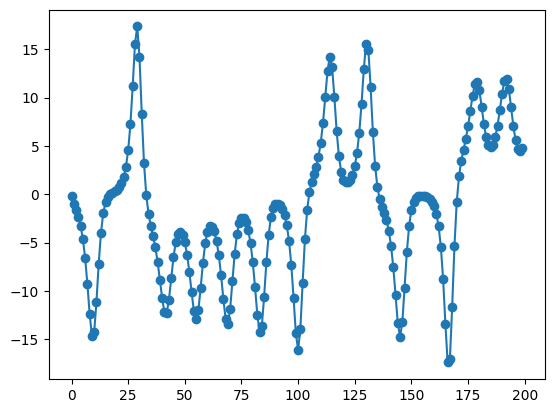

In [6]:
plt.plot(trajectory[-1000::5,0], 'o-')

In [7]:
print("First point of full trajectory:", trajectory[0])
print("Second point of full trajectory:", trajectory[1])
print("Third point of full trajectory:", trajectory[2])


First point of full trajectory: [1. 1. 1.]
Second point of full trajectory: [1.01256719 1.2599178  0.98489097]
Third point of full trajectory: [1.04882371 1.52399713 0.97311422]


# Feed Forward Neural Network

In [8]:
def make_windows(trajectory, window_size, horizon = 1):
    # horizon is the number of steps ahead to predict

    N = trajectory.shape[0]
    X, y = [], []

    for i in range(N - window_size - horizon + 1):
        X.append((trajectory[i : i + window_size]).flatten())
        y.append((trajectory[i + window_size : i + window_size + horizon]).flatten())

    return np.array(X), np.array(y)

# Neural Network Class

In [9]:
class NeuralNetwork:
    def __init__(self, input_size = 64, hidden_size = 30, output_size = 10, learning_rate = 1e-3, epochs = 1000):
        # Hyperparameters
        self.learning_rate = learning_rate
        self.epochs = epochs
        
        # Weights & bias initialization with small random values
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01  
        self.b1 = np.zeros((1, hidden_size))                       
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01 
        self.b2 = np.zeros((1, output_size))                       #

    # ReLU activation function
    def ReLU(self, x):
        return np.maximum(0, x)

    # Derivative of the ReLU function
    def ReLU_deriv(self, x):
        return np.where(x > 0, 1, 0)

    # Linear Activation Function
    def Linear(self, x):
        return x

    def Linear_deriv(self, x):
        return np.ones_like(x)

    # Forward propagation: computes the activations for the hidden and output layers
    def forward_propagation(self, x):
        # Hidden layer
        self.z1 = x @ self.W1 + self.b1
        self.a1 = self.ReLU(self.z1)
    
        # Output layer
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.Linear(self.z2)
        
        return self.a2

    # Compute the cost using Mean Squared Error
    def compute_cost(self, y_pred, y_true):
        return np.mean((y_pred - y_true)**2)

    # Back propagation: computes gradients for updating weights and biases
    def back_propagation(self, x, y):       
        m = y.shape[0]
    
        # Compute error at output layer
        error2 = 2 * (self.a2 - y) * self.Linear_deriv(self.z2)

        # Compute gradients for weights and biases for the output layer
        grad_W2 = (self.a1.T @ error2) / m
        grad_b2 = np.sum(error2, axis = 0, keepdims = True) / m

        # Backpropagate the error to the hidden layer
        error1 = (error2 @ self.W2.T) * self.ReLU_deriv(self.z1)

        # Compute gradients for weights and biases for the hidden layer
        grad_W1 = (x.T @ error1) / m
        grad_b1 = np.sum(error1, axis = 0, keepdims = True) / m

        return grad_W1, grad_b1, grad_W2, grad_b2

    # Update the network parameters (weights and biases) using the computed gradients
    def update_parameters(self, grad_W1, grad_b1, grad_W2, grad_b2):
        self.W2 = self.W2 - (self.learning_rate * grad_W2)
        self.b2 = self.b2 - (self.learning_rate * grad_b2)
        self.W1 = self.W1 - (self.learning_rate * grad_W1)
        self.b1 = self.b1 - (self.learning_rate * grad_b1)

    # Train the neural network by iterating over epochs
    def train(self, x, y, optimizer='sgd'):
        optimizer = optimizer.lower()
        
        if optimizer not in ('sgd', 'adam'):
            raise ValueError("Optimizer must be 'sgd' or 'adam'")

        # Adam hyperparameters
        if optimizer == 'adam':
            beta1, beta2 = 0.9, 0.999
            eps = 1e-8
            # Initialize 1st & 2nd moment vectors
            m_W1 = np.zeros_like(self.W1); v_W1 = np.zeros_like(self.W1)
            m_b1 = np.zeros_like(self.b1); v_b1 = np.zeros_like(self.b1)
            m_W2 = np.zeros_like(self.W2); v_W2 = np.zeros_like(self.W2)
            m_b2 = np.zeros_like(self.b2); v_b2 = np.zeros_like(self.b2)

        for epoch in range(1, self.epochs + 1):
            # Perform forward propagation to get outputs
            Y_pred = self.forward_propagation(x)

            # Compute gradients via back propagation
            grad_W1, grad_b1, grad_W2, grad_b2 = self.back_propagation(x, y)

            if optimizer == 'sgd':
                # Update network parameters with the gradients using Standard SGD
                self.update_parameters(grad_W1, grad_b1, grad_W2, grad_b2)

            else:
                # Adam updates
                m_W1 = beta1 * m_W1 + (1 - beta1) * grad_W1
                v_W1 = beta2 * v_W1 + (1 - beta2) * (grad_W1 ** 2)
                m_b1 = beta1 * m_b1 + (1 - beta1) * grad_b1
                v_b1 = beta2 * v_b1 + (1 - beta2) * (grad_b1 ** 2)
                m_W2 = beta1 * m_W2 + (1 - beta1) * grad_W2
                v_W2 = beta2 * v_W2 + (1 - beta2) * (grad_W2 ** 2)
                m_b2 = beta1 * m_b2 + (1 - beta1) * grad_b2
                v_b2 = beta2 * v_b2 + (1 - beta2) * (grad_b2 ** 2)

                # Bias-corrected moments
                mW1_hat = m_W1 / (1 - beta1 ** epoch)
                vW1_hat = v_W1 / (1 - beta2 ** epoch)
                mb1_hat = m_b1 / (1 - beta1 ** epoch)
                vb1_hat = v_b1 / (1 - beta2 ** epoch)
                mW2_hat = m_W2 / (1 - beta1 ** epoch)
                vW2_hat = v_W2 / (1 - beta2 ** epoch)
                mb2_hat = m_b2 / (1 - beta1 ** epoch)
                vb2_hat = v_b2 / (1 - beta2 ** epoch)

                # Update parameters
                self.W1 -= self.learning_rate * mW1_hat / (np.sqrt(vW1_hat) + eps)
                self.b1 -= self.learning_rate * mb1_hat / (np.sqrt(vb1_hat) + eps)
                self.W2 -= self.learning_rate * mW2_hat / (np.sqrt(vW2_hat) + eps)
                self.b2 -= self.learning_rate * mb2_hat / (np.sqrt(vb2_hat) + eps)

            # Every 100 epochs, compute and print the cost for monitoring convergence
            if (epoch%100 == 0):
                cost = self.compute_cost(Y_pred, y)
                print(f"Epoch {epoch}, Cost: {cost:.6f}, Optimizer: {optimizer.upper()}")

    # Predict class labels for input data
    def predict(self, x):
        return self.forward_propagation(x)

# Training the Neural Network

In [10]:
window_size = 20
horizon     = 1

X, y = make_windows(trajectory, window_size, horizon)

### Splitting into Training, Validation, and Test Set

In [11]:
n = X.shape[0]
n_train = int(0.70*n)
n_val   = int(0.15*n)

X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test,  y_test  = X[n_train+n_val:], y[n_train+n_val:]

In [12]:
print(f"Total points: {N}")
print(f"  Training : {X_train.shape[0]} samples")
print(f"  Validation: {X_val.shape[0]} samples")
print(f"  Testing  : {X_test.shape[0]} samples")

Total points: 50000
  Training : 34986 samples
  Validation: 7497 samples
  Testing  : 7498 samples


### Normalizing the Data Points

In [13]:
eps = 1e-8   # Added to standard deviation values to avoid division by zero error
Xmu,  Xstd  = X_train.mean(0, keepdims=True), X_train.std(0, keepdims=True) + eps
ymu,  ystd  = y_train.mean(0, keepdims=True), y_train.std(0, keepdims=True) + eps

X_train = (X_train - Xmu)/Xstd
X_val   = (X_val   - Xmu)/Xstd
X_test  = (X_test  - Xmu)/Xstd

y_train = (y_train - ymu)/ystd
y_val   = (y_val   - ymu)/ystd
y_test  = (y_test  - ymu)/ystd

In [14]:
model = NeuralNetwork(
    input_size    = window_size * 3,
    hidden_size   = 30,
    output_size   = horizon * 3,
    learning_rate = 1e-3,
    epochs        = 1000 
)

model.train(X_train, y_train)

Epoch 100, Cost: 0.982406, Optimizer: SGD
Epoch 200, Cost: 0.924065, Optimizer: SGD
Epoch 300, Cost: 0.745629, Optimizer: SGD
Epoch 400, Cost: 0.494072, Optimizer: SGD
Epoch 500, Cost: 0.354917, Optimizer: SGD
Epoch 600, Cost: 0.282497, Optimizer: SGD
Epoch 700, Cost: 0.217698, Optimizer: SGD
Epoch 800, Cost: 0.157832, Optimizer: SGD
Epoch 900, Cost: 0.111347, Optimizer: SGD
Epoch 1000, Cost: 0.080126, Optimizer: SGD


In [15]:
y_hat_val = model.predict(X_val)*ystd + ymu
mse_val   = np.mean((y_hat_val - (y_val*ystd + ymu))**2)
print("Validation MSE:", mse_val)

Validation MSE: 6.055088090778603


Typical x, y, z values on the attractor are roughly in the range [-20, 40]. RMSE = sqrt(MSE) = 2.55. So, on average, each coordinate is off by ≈ 2.5 units one time-step (Δt=0.01) into the future.

In [16]:
best_params = {'window_size': 20, 'hidden_size': 100, 'learning_rate': 0.01, 'batch_size': 64, 'optimizer': 'adam', 'epochs': 1000}

In [17]:
X_trainval, y_trainval = make_windows(trajectory[:n_train+n_val], best_params['window_size'])
X_test_w,   y_test_w   = make_windows(trajectory[n_train+n_val:], best_params['window_size'])

X_trainval = (X_trainval - Xmu) / Xstd
y_trainval = (y_trainval - ymu) / ystd

X_test_w = (X_test_w - Xmu) / Xstd
y_test_w = (y_test_w - ymu) / ystd

final_model = NeuralNetwork(
    input_size  = best_params['window_size'] * 3,
    hidden_size = best_params['hidden_size'],
    learning_rate = best_params['learning_rate'],
    epochs      = best_params['epochs'],
    output_size = 3
)

final_hist = final_model.train(
    X_trainval, y_trainval,
    optimizer   = best_params['optimizer']    
)

Epoch 100, Cost: 0.001156, Optimizer: ADAM
Epoch 200, Cost: 0.000232, Optimizer: ADAM
Epoch 300, Cost: 0.000088, Optimizer: ADAM
Epoch 400, Cost: 0.000051, Optimizer: ADAM
Epoch 500, Cost: 0.000041, Optimizer: ADAM
Epoch 600, Cost: 0.000029, Optimizer: ADAM
Epoch 700, Cost: 0.000212, Optimizer: ADAM
Epoch 800, Cost: 0.000024, Optimizer: ADAM
Epoch 900, Cost: 0.000040, Optimizer: ADAM
Epoch 1000, Cost: 0.000018, Optimizer: ADAM


In [18]:
test_pred = final_model.predict(X_test_w)
test_mse  = np.mean((test_pred - y_test_w)**2)
print("Test MSE:", test_mse)

Test MSE: 2.6717944311986484e-05


RMSE = 0.074. So, on average, each coorainet is off by ~0.07 units just one time-step (Δt = 0.01) into the future. It captures the immediate local dynamics of a chaotic system with less than a tenth of a unit error

# Forecasting

In [22]:
# Parameters
window_size = best_params['window_size']
n_forecast  = 600
coords      = ['x','y','z']
idxs   = [0,1,2]

# Seed window from the held-out test split
L0     = n_train + n_val
window = trajectory[L0 : L0 + window_size].copy()

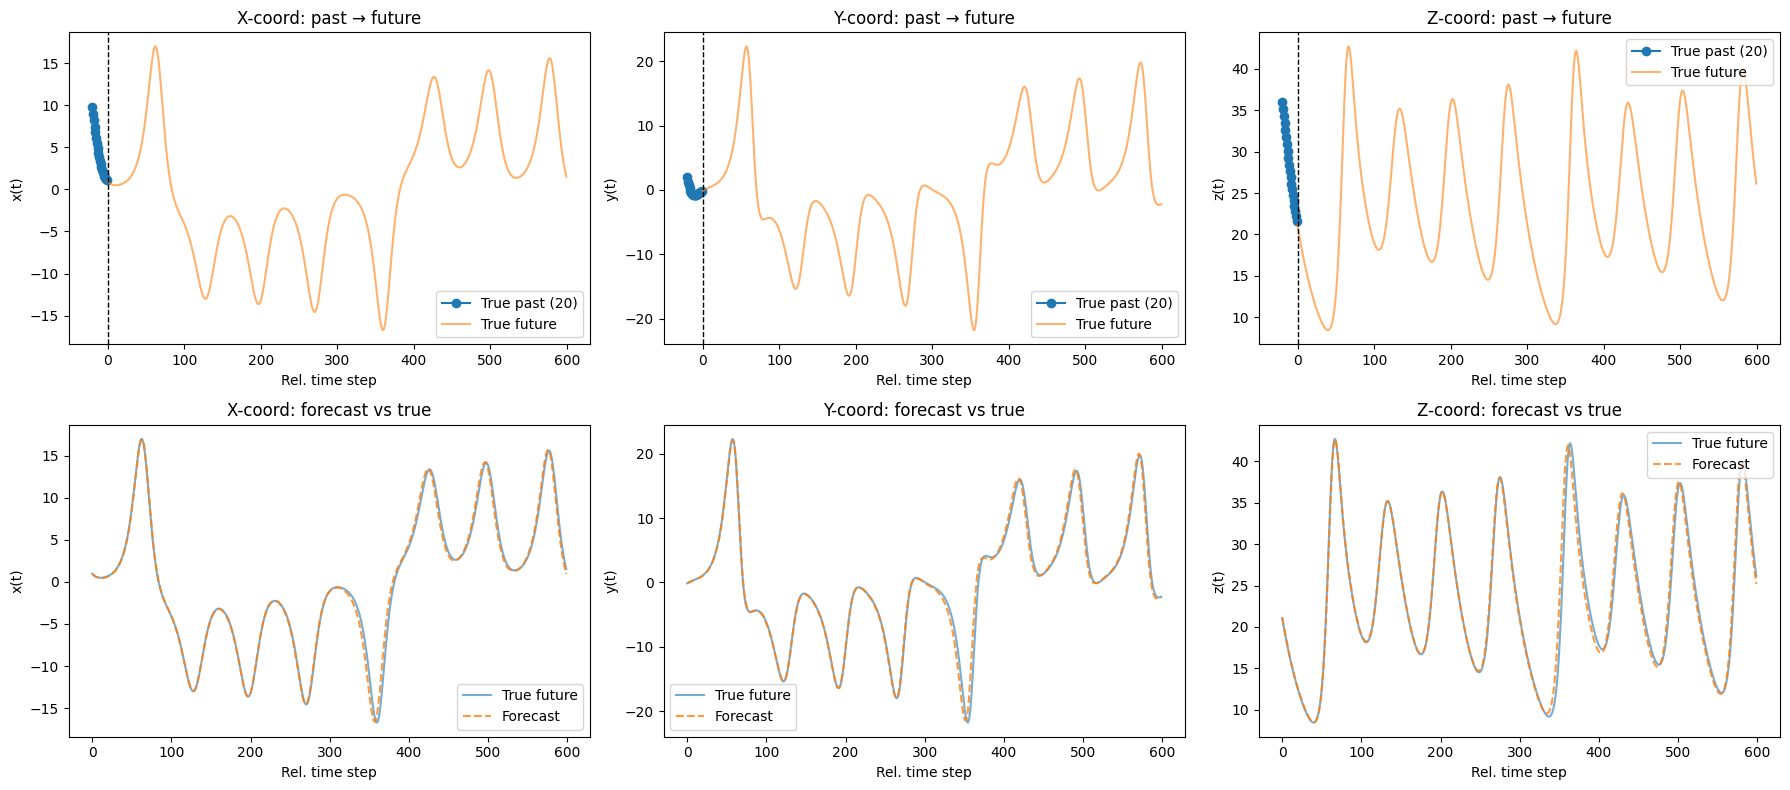

In [23]:
# Closed-loop forecast
forecast = np.zeros((n_forecast, 3))

for t in range(n_forecast):
    x_norm = (window.flatten()[None, :] - Xmu) / Xstd
    y_norm = final_model.predict(x_norm)
    y      = (y_norm * ystd + ymu).flatten()
    forecast[t] = y
    window     = np.vstack([window[1:], y])

# Time axes
t_past = np.arange(-window_size, 0)
t_fut  = np.arange(0, n_forecast)

fig, axes = plt.subplots(2, 3, figsize=(18, 8))

for col, (coord, idx) in enumerate(zip(coords, idxs)):
    # Plot 1: True past → True future
    true_past   = trajectory[L0 : L0 + window_size, idx]
    true_future = trajectory[L0 + window_size : L0 + window_size + n_forecast, idx]
    axes[0, col].plot(t_past, true_past, 'o-', label=f"True past ({window_size})")
    axes[0, col].plot(t_fut,  true_future, '-',  label="True future", alpha=0.6)
    axes[0, col].axvline(0, color='k', linestyle='--', lw=1)
    axes[0, col].set_title(f"{coord.upper()}-coord: past → future")
    axes[0, col].set_xlabel("Rel. time step");  axes[0, col].set_ylabel(f"{coord}(t)")
    axes[0, col].legend()

    # Plot 2: Closed-loop forecast vs True
    fcst = forecast[:, idx]
    axes[1, col].plot(t_fut, true_future, label="True future", alpha=0.6)
    axes[1, col].plot(t_fut, fcst, '--', label="Forecast",    alpha=0.8)
    axes[1, col].set_title(f"{coord.upper()}-coord: forecast vs true")
    axes[1, col].set_xlabel("Rel. time step");  axes[1, col].set_ylabel(f"{coord}(t)")
    axes[1, col].legend()

plt.tight_layout()
plt.show()

Increasing the Number of POints into the Future we Forecast

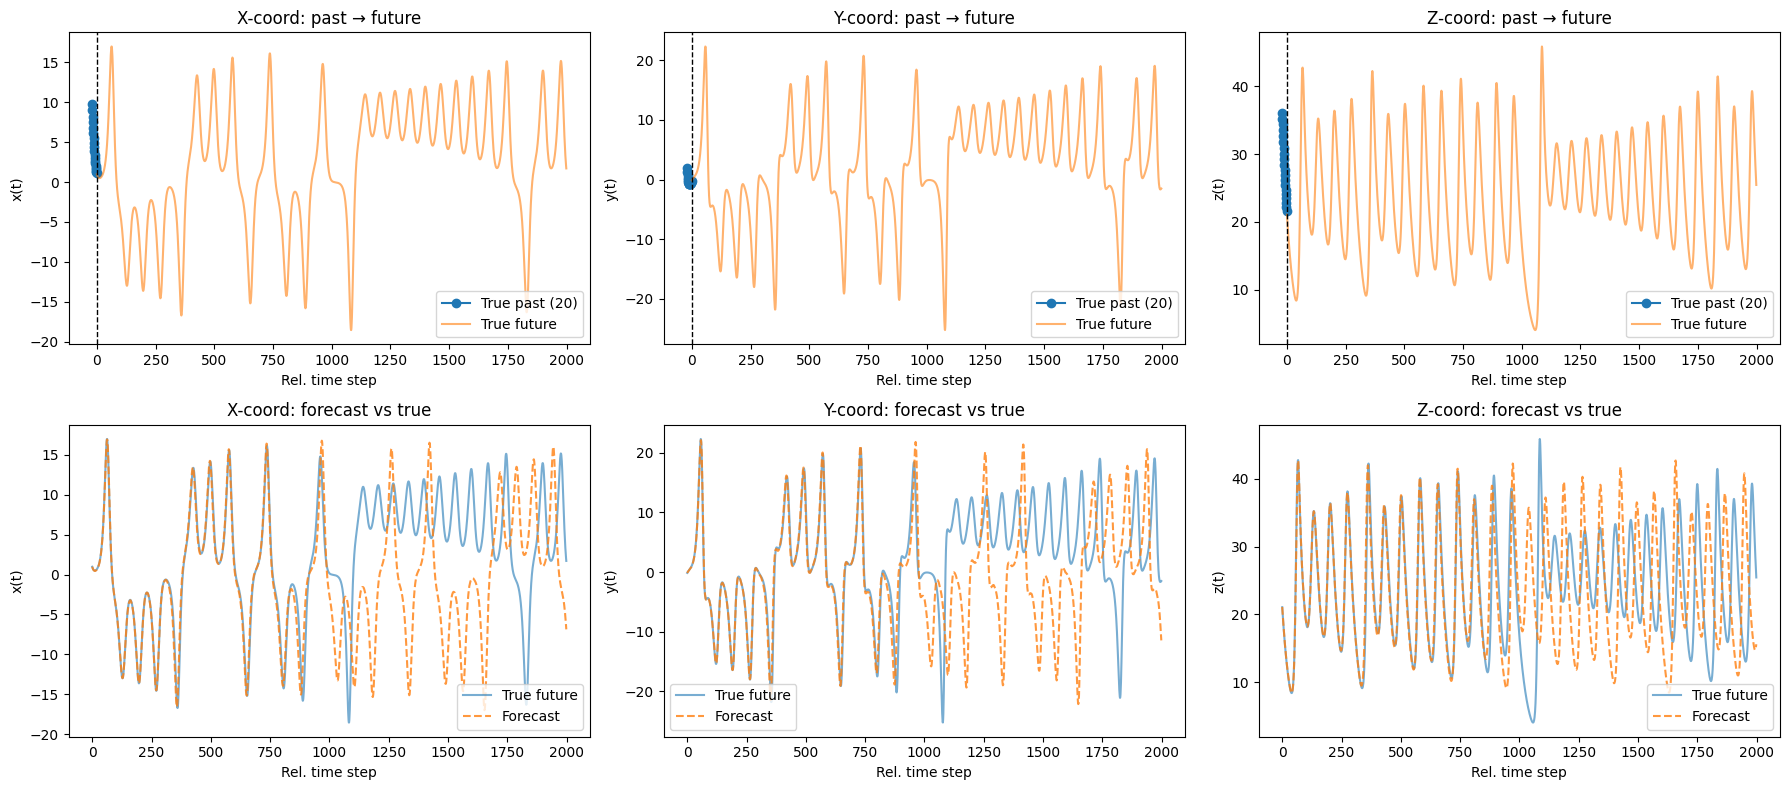

In [24]:
# Parameters
window_size = best_params['window_size']
n_forecast  = 2000
coords      = ['x','y','z']
idxs   = [0,1,2]

# Seed window from the held-out test split
L0     = n_train + n_val
window = trajectory[L0 : L0 + window_size].copy()


# Closed-loop forecast
forecast = np.zeros((n_forecast, 3))

for t in range(n_forecast):
    x_norm = (window.flatten()[None, :] - Xmu) / Xstd
    y_norm = final_model.predict(x_norm)
    y      = (y_norm * ystd + ymu).flatten()
    forecast[t] = y
    window     = np.vstack([window[1:], y])

# Time axes
t_past = np.arange(-window_size, 0)
t_fut  = np.arange(0, n_forecast)

fig, axes = plt.subplots(2, 3, figsize=(18, 8))

for col, (coord, idx) in enumerate(zip(coords, idxs)):
    # Plot 1: True past → True future
    true_past   = trajectory[L0 : L0 + window_size, idx]
    true_future = trajectory[L0 + window_size : L0 + window_size + n_forecast, idx]
    axes[0, col].plot(t_past, true_past, 'o-', label=f"True past ({window_size})")
    axes[0, col].plot(t_fut,  true_future, '-',  label="True future", alpha=0.6)
    axes[0, col].axvline(0, color='k', linestyle='--', lw=1)
    axes[0, col].set_title(f"{coord.upper()}-coord: past → future")
    axes[0, col].set_xlabel("Rel. time step");  axes[0, col].set_ylabel(f"{coord}(t)")
    axes[0, col].legend()

    # Plot 2: Closed-loop forecast vs True
    fcst = forecast[:, idx]
    axes[1, col].plot(t_fut, true_future, label="True future", alpha=0.6)
    axes[1, col].plot(t_fut, fcst, '--', label="Forecast",    alpha=0.8)
    axes[1, col].set_title(f"{coord.upper()}-coord: forecast vs true")
    axes[1, col].set_xlabel("Rel. time step");  axes[1, col].set_ylabel(f"{coord}(t)")
    axes[1, col].legend()

plt.tight_layout()
plt.show()

Estimate Lyapunov exponent & time

In [ ]:
ts = trajectory[:,0]  # use x-coordinate
le1 = nolds.lyap_r(ts, emb_dim=3, lag=10, min_tsep=100)
lyap_time = 1/le1
print(f"Estimated largest Lyapunov exponent λ₁ ≃ {le1:.4f} per step")
print(f"Lyapunov time ≃ {lyap_time:.1f} steps\n")

RMSE vs horizon for iterative forecasts

In [ ]:
horizons = [1, 2, 3, 5, 10, 20, 40]
iter_rmse = []

for h in horizons:
    # Closed-loop forecast of length h
    window = trajectory[L0:L0+window_size].copy()
    preds = []

    for _ in range(h):
        x_norm = (window.flatten()[None, :] - Xmu) / Xstd
        y_norm = final_model.predict(x_norm)
        y_pred = (y_norm * ystd + ymu).flatten()
        preds.append(y_pred[0])
        window = np.vstack([window[1:], y_pred])
        
    true_x = trajectory[L0 + window_size:L0 + window_size + h, 0]
    rmse   = np.sqrt(np.mean((np.array(preds) - true_x)**2))
    iter_rmse.append(rmse)

Train Model for h = 10

In [ ]:
h = 10
Xh, yh = make_windows(trajectory, window_size, horizon=h)
n, n_tr, n_va = Xh.shape[0], int(0.7*Xh.shape[0]), int(0.15*Xh.shape[0])
Xh_train = (Xh[:n_tr] - Xmu)/Xstd
yh_train = (yh[:n_tr] - ymu)/ystd
Xh_test  = (Xh[n_tr+n_va:] - Xmu)/Xstd
yh_test  = yh[n_tr+n_va:]

model_h = NeuralNetwork(
    input_size    = window_size*3,
    hidden_size   = best_params['hidden_size'],
    output_size   = 3*h,
    learning_rate = best_params['learning_rate'],
    epochs        = best_params['epochs'],
)

model_h.train(Xh_train, yh_train, optimizer=best_params['optimizer'])

yhat_h = model_h.predict(Xh_test[:1]).flatten()*ystd + ymu
x_true = yh_test[0, 0::3]
x_hat  = yhat_h[0::3]
steps  = np.arange(1, h+1)

plt.figure(figsize=(6,4))
plt.plot(steps, x_true, 'o-', label='True x(t+h)')
plt.plot(steps, x_hat,  'x--', label='Direct forecast')
plt.xlabel("Step ahead")
plt.ylabel("x-value")
plt.title("Direct model: x-coordinate forecast (h=10)")
plt.legend()
plt.tight_layout()
plt.show()

Iterative closed-loop forecast example

In [ ]:
h = 100
window = trajectory[L0:L0+window_size].copy()
iter_preds = []
for _ in range(h):
    x_norm = (window.flatten()[None, :] - Xmu) / Xstd
    y_norm = final_model.predict(x_norm)
    y_pred = (y_norm * ystd + ymu).flatten()
    iter_preds.append(y_pred[0])
    window = np.vstack([window[1:], y_pred])

true_100 = trajectory[L0+window_size:L0+window_size+h, 0]
t_steps  = np.arange(h)

plt.figure(figsize=(6,4))
plt.plot(t_steps, true_100,    '-',  label='True x')
plt.plot(t_steps, iter_preds, '--', label='Iterative forecast')
plt.xlabel("Relative step")
plt.ylabel("x-value")
plt.title("Closed-loop x forecast (100 steps)")
plt.legend()
plt.tight_layout()
plt.show()